In [1]:
# af_indirs = snakemake.params.af_indirs
# indir = snakemake.params.indir
# outdir = snakemake.params.outdir
# donor = snakemake.wildcards.d
# weights = snakemake.params.weights
# anno_cells_meta_f = snakemake.input.anno_cells_meta_f
# objectives_l = snakemake.params.get("objectives_l", 
#                                     ["variants_with_clone_norm_by_1_over_nclones_with_variant", 
#                                      "max_clone_ncells_over_nclones", "max_clone_ncells_over_ncells", 
#                                      "pct_thresh","other_pct_thresh", 
#                                      "n_vars", "obj_nclones_more_than_one_unique"])
try: 
    af_indirs = snakemake.params.af_indirs
    indir = snakemake.params.indir
    outdir = snakemake.params.outdir
    donor = snakemake.wildcards.d
    weights = snakemake.params.weights
    anno_cells_meta_f = snakemake.input.anno_cells_meta_f
    objectives_l = snakemake.params.get("objectives_l", 
                                        ["variants_with_clone_norm_by_1_over_nclones_with_variant", 
                                         "max_clone_ncells_over_nclones", "max_clone_ncells_over_ncells", 
                                         "pct_thresh","other_pct_thresh", 
                                         "n_vars", "obj_nclones_more_than_one_unique"])
except NameError:
    af_indirs = "/data/Mito_Trace/output/pipeline/v04/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_30/"
    indir = "/data/Mito_Trace/output/pipeline/v04/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/enriched_barcodes/clones/variants_init/knn/kparam_30/donor0/"
    outdir = "/data/Mito_Trace/output/pipeline/v04/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/enriched_barcodes/clones/variants_init/knn/kparam_30/donor0/optim_results/"
    donor = 0
    anno_cells_meta_f = "/data/Mito_Trace/output/pipeline/v04/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_30/gff_A2_black/annotation_clones/se_cells_meta_labels.tsv"
    weights = [1,0,0,1,-1, 1, 1]
    objectives_l = ["variants_with_clone_norm_by_1_over_nclones_with_variant", 
                    "max_clone_ncells_over_nclones", "max_clone_ncells_over_ncells", 
                    "pct_thresh","other_pct_thresh", "n_vars", "obj_nclones_more_than_one_unique"] #"nvars"

    
param_names = ["pct_thresh","af_thresh", "other_pct_thresh"]


In [2]:
af_indirs

'/data/Mito_Trace/output/pipeline/v04/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_30/'

In [3]:
import src.clone_variants_optim  as optim
from mplh import cluster_help as ch

from dynamicTreeCut import cutreeHybrid
from scipy.spatial.distance import pdist
import numpy as np
from scipy.cluster.hierarchy import linkage

import mplh.cluster_help as ch
import mplh.fig_utils as fu

fig_utils from mplh


In [4]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import matplotlib
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from os.path import join, exists, dirname
from glob import glob
import pickle
from icecream import ic
ic.disable()
np.set_printoptions(formatter={'float': lambda x: format(x, '.3f')})
# matplotlib.rcParams['ps.useafm'] = False
# matplotlib.rcParams['pdf.use14corefonts'] = True
# matplotlib.rcParams['text.usetex'] = False

# Load results and get top 10% of them

In [5]:
obj_norm_results = pd.read_csv(join(indir, "objectives_norm.csv"), index_col=0)
obj_results = pd.read_csv(join(indir, "objectives.csv"), index_col=0)
obj_results = pd.read_csv(join(indir, "objectives_rank.csv"), index_col=0)
param_results = pd.read_csv(join(indir, "params.csv"), index_col=0)

# top 10%
top10perc_n = int(obj_norm_results.shape[0]*0.1)
obj_norm_top10perc = obj_norm_results.iloc[:top10perc_n]
top10perc_n

param_results = param_results.loc[obj_norm_top10perc.index]
# obj_norm_top10perc_params = pd.merge(left=obj_norm_top10perc, right=param_results, left_index=True, right_index=True, how="left", 
#                                      suffixes=["_obj", ""])


In [6]:
# from sklearn.mixture import GMM
#from sklearn import mixture
#model = mixture.GaussianMixture(n_components=3, covariance_type='full')
#gmm = model.fit(X)
#
# gmm = GMM(n_components=4).fit(X)
# labels = gmm.predict(X)
# plt.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis');

## Cluster top results by objectives and get a dynamic tree cut of the dendrogram

In [7]:
obj_norm_top10perc

,variants_with_clone_norm_by_1_over_nclones_with_variant,max_clone_ncells_over_nclones,max_clone_ncells_over_ncells,pct_thresh,other_pct_thresh,n_vars,obj_nclones_more_than_one_unique,multi
421,0.000699,0.000389,0.000777,0.000028,0.000015,0.000730,0.004619,0.006060
441,0.000699,0.000389,0.000777,0.000028,0.000029,0.000730,0.004619,0.006047
461,0.000699,0.000389,0.000777,0.000028,0.000043,0.000730,0.004619,0.006033
561,0.000735,0.000665,0.000810,0.000028,0.000112,0.000756,0.004619,0.006026
481,0.000699,0.000389,0.000777,0.000028,0.000057,0.000730,0.004619,0.006019
...,...,...,...,...,...,...,...,...
3920,0.000364,0.000397,0.000359,0.000138,0.000222,0.000391,0.000000,0.000671
4340,0.000364,0.000397,0.000359,0.000152,0.000236,0.000391,0.000000,0.000671
4760,0.000364,0.000397,0.000359,0.000166,0.000250,0.000391,0.000000,0.000671
843,0.000343,0.000142,0.000338,0.000041,0.000029,0.000313,0.000000,0.000669


..cutHeight not given, setting it to 0.00354542999544845  ===>  99% of the (truncated) height range in dendro.
..done.


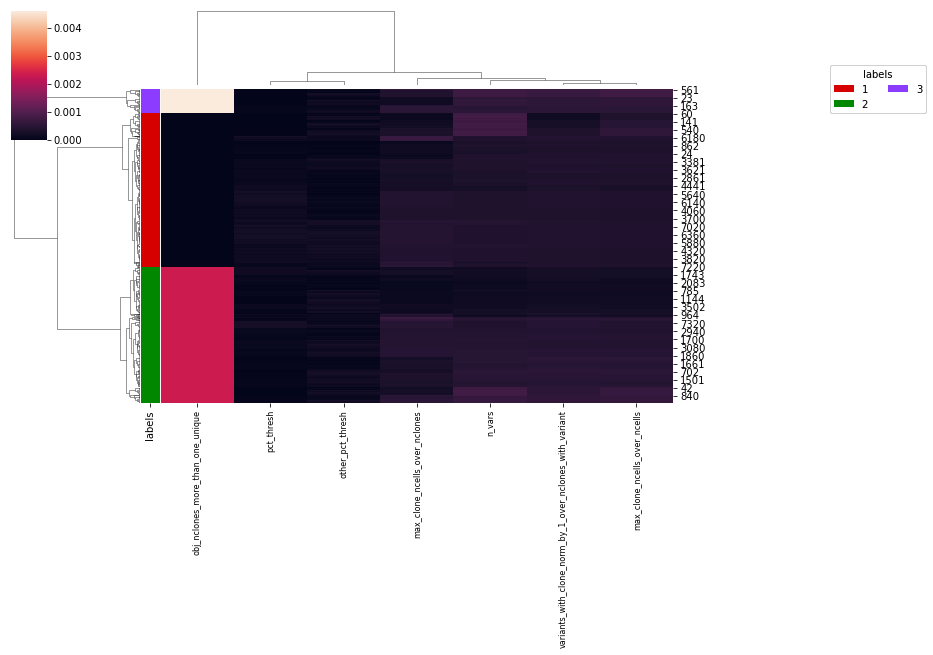

In [8]:

# g = sns.clustermap(obj_norm_top10perc)
# g.fig.suptitle("Top 10% objective scores")
# plt.savefig(join(outdir, "top10_objectives.png"))


#d = np.transpose(np.arange(1,10001).reshape(100,100))

distances = pdist(obj_norm_top10perc.drop("multi", axis=1).values, "euclidean")
link = linkage(distances, "average")
# try:
#     clusters = cutreeHybrid(link, distances)["labels"]
# except IndexError: 
#     print("too small, using each one as its own label")
#     clusters = np.arange(1,len(obj_norm_top10perc)+1)

clusters = cutreeHybrid(link, distances, minClusterSize=1)["labels"]    
# ..cutHeight not given, setting it to 495.1  ===>  99% of the (truncated) height range in dendro.
# ..done.
#clusters["labels"]
#print('clusters', clusters)
#clusters = pd.DataFrame({"ID":clusters["ID"], "labels": clusters["labels"]}, index=obj_norm_top10perc.index)#[["ID", "labels"]]
clusters = pd.DataFrame({"labels": clusters}, index=obj_norm_top10perc.index)#[["ID", "labels"]]

clusters["ID"] = obj_norm_top10perc.index

param_results = pd.merge(clusters, param_results, left_index=True, right_index=True, how="inner")
ch.plot_cluster(obj_norm_top10perc.drop("multi", axis=1), row_meta=clusters[["labels"]])
plt.savefig(join(outdir, "top10perc_param_group_clusters.pdf"), dpi=300, bbox_inches='tight', pad_inches=1)

## Get average parameters for each params-cluster 

In [9]:
top_params_mean_df = param_results.groupby("labels").mean().drop("ID", axis=1)
top_params_mean_df

,pct_thresh,other_pct_thresh,af_thresh
labels,,,
1,0.463812,0.444917,0.037044
2,0.298442,0.507648,0.079766
3,0.115179,0.513036,0.072857


##  Get the clone-variant table for each params-cluster


### First load the AF, DP, and cells_meta data

In [10]:
af_indir = join(af_indirs, "sc_af", f"donor{donor}")

AF_df = pd.read_csv(join(af_indir, "af.tsv"), index_col=0, sep="\t")
DP_df = pd.read_csv(join(af_indir, "dp.tsv"), index_col=0, sep="\t")

cells_meta = pd.read_csv(join(af_indirs, "cells_meta.tsv"), sep='\t', index_col="ID")#.sort_values(["donor", "lineage"])
cells_meta["name"] = cells_meta["donor"].astype(str)+"_"+cells_meta["lineage"].astype(str)
# if "donor_index" in cells_meta.columns and "lineage_index" in cells_meta.columns:
#     cells_meta = cells_meta.sort_values(["donor_index", "lineage_index"])
#AD_df = pd.merge(AD_df, vcf[["#CHROM", "POS", "ALT"]], how="inner", left_index=True,right_index=True).set_index(["#CHROM", "POS", "ALT"])
curr_labels = cells_meta[cells_meta["donor"].astype(int)==int(donor)]
curr_labels

conditions = curr_labels["condition"].unique()
conditions

def rm_high(df, thresh, pct_thresh):
    return df.loc[~(((df>thresh).sum(axis=1)>pct_thresh*df.shape[0]))]

def rm_low(df, thresh, pct_thresh):
    return df.loc[~((df<thresh).sum(axis=1)>(pct_thresh*df.shape[1]))]

    #return df.loc[~(((df<=thresh).sum(axis=1)>pct_thresh*df.shape[0]))]
#df[(df<0.01).sum(axis=1)]

## Get donor inds
donor_inds = AF_df.index[((AF_df>0.9).sum(axis=1)>(0.9*AF_df.shape[1]))]

AF_df.shape

(68, 7002)

## Then, create the clone-var table for the clustered params and get their objective scores based on the weights
Store the results in results_norm_params, which has params, objectives, and solution cluster  
Also store the tables in all_df, which is the long-form of clone, variant, ncells, and params

In [11]:
all_df = []
all_objs = {}
for ind, val in top_params_mean_df.iterrows():
    print(ind)
    obj_out, data = optim.evaluate_series(val, AF_df, DP_df, curr_labels, return_data=True)
    all_df.append(data["all_unique_df"])
    all_objs[ind] = obj_out 
all_df = pd.concat(all_df)

results_df = pd.DataFrame(all_objs).transpose()
results_norm = optim.set_multi(results_df, weights)
rank_df = optim.set_multi_rank(results_norm, weights)

all_df["params"] = all_df.apply(optim.params_to_str, axis=1,
                                args=(param_names,))

## merge param and results
results_norm_params = pd.merge(left=top_params_mean_df, right=results_norm, right_index=True, left_index=True, suffixes=["", "_obj"])

results_norm_params["params"] = results_norm_params.apply(optim.params_to_str, axis=1,
                                args=(param_names,))
results_norm_params.index.name = "solution_cluster"
results_norm_params = results_norm_params.reset_index().set_index("params")


1
2
3
(3, 7)
objs_total variants_with_clone_norm_by_1_over_nclones_with_variant      37.138095
max_clone_ncells_over_nclones                              3546.257143
max_clone_ncells_over_ncells                                 40.075640
pct_thresh                                                    0.877433
other_pct_thresh                                              1.465601
dtype: float64


### sort by multi


In [12]:
results_norm_params = results_norm_params.sort_values(["multi"])[::-1]

results_norm_params

,solution_cluster,pct_thresh,other_pct_thresh,af_thresh,variants_with_clone_norm_by_1_over_nclones_with_variant,max_clone_ncells_over_nclones,max_clone_ncells_over_ncells,pct_thresh_obj,other_pct_thresh_obj,n_vars,obj_nclones_more_than_one_unique,multi
params,,,,,,,,,,,,
pct_thresh=0.115\naf_thresh=0.073\nother_pct_thresh=0.513\n,3,0.115179,0.513036,0.072857,0.432620,0.289432,0.431828,0.131268,0.350051,0.42,1.0,1.633836
pct_thresh=0.464\naf_thresh=0.037\nother_pct_thresh=0.445\n,1,0.463812,0.444917,0.037044,0.309655,0.517165,0.303243,0.528601,0.303573,0.30,0.0,0.834683
pct_thresh=0.298\naf_thresh=0.080\nother_pct_thresh=0.508\n,2,0.298442,0.507648,0.079766,0.257725,0.193403,0.264928,0.340131,0.346375,0.28,0.0,0.531481


## Add multi_obj and solution_cluster label to the long clone-table and to the results

In [13]:
all_df["multi_obj"] = all_df.apply(lambda x: results_norm_params.loc[x["params"], "multi"], axis=1)
all_df["solution_cluster"] = all_df.apply(lambda x: results_norm_params.loc[x["params"], "solution_cluster"], axis=1)
all_df["params_multi"] = all_df.apply(optim.params_and_multi_str, axis=1)
clones_order, variants_order, heatmap_input = optim.prep_long_heatmap(all_df)
all_df["solution_params_obj"] = all_df.apply(lambda x: f'solution:{x["solution_cluster"]}\n {x["params_multi"]}',axis=1)
all_df

results_norm_params = results_norm_params.reset_index()
results_norm_params["multi_obj"] = results_norm_params["multi"]
results_norm_params["params_multi"] = results_norm_params.apply(optim.params_and_multi_str, axis=1)

results_norm_params["solution_params_obj"] = results_norm_params.apply(lambda x: f'solution:{x["solution_cluster"]}\n {x["params_multi"]}',axis=1)
results_norm_params

,params,solution_cluster,pct_thresh,other_pct_thresh,af_thresh,variants_with_clone_norm_by_1_over_nclones_with_variant,max_clone_ncells_over_nclones,max_clone_ncells_over_ncells,pct_thresh_obj,other_pct_thresh_obj,n_vars,obj_nclones_more_than_one_unique,multi,multi_obj,params_multi,solution_params_obj
0,pct_thresh=0.115\naf_thresh=0.073\nother_pct_t...,3,0.115179,0.513036,0.072857,0.432620,0.289432,0.431828,0.131268,0.350051,0.42,1.0,1.633836,1.633836,params:\npct_thresh=0.115\naf_thresh=0.073\not...,solution:3\n params:\npct_thresh=0.115\naf_thr...
1,pct_thresh=0.464\naf_thresh=0.037\nother_pct_t...,1,0.463812,0.444917,0.037044,0.309655,0.517165,0.303243,0.528601,0.303573,0.30,0.0,0.834683,0.834683,params:\npct_thresh=0.464\naf_thresh=0.037\not...,solution:1\n params:\npct_thresh=0.464\naf_thr...
2,pct_thresh=0.298\naf_thresh=0.080\nother_pct_t...,2,0.298442,0.507648,0.079766,0.257725,0.193403,0.264928,0.340131,0.346375,0.28,0.0,0.531481,0.531481,params:\npct_thresh=0.298\naf_thresh=0.080\not...,solution:2\n params:\npct_thresh=0.298\naf_thr...


## Plot objective scores across different params-cluster labels

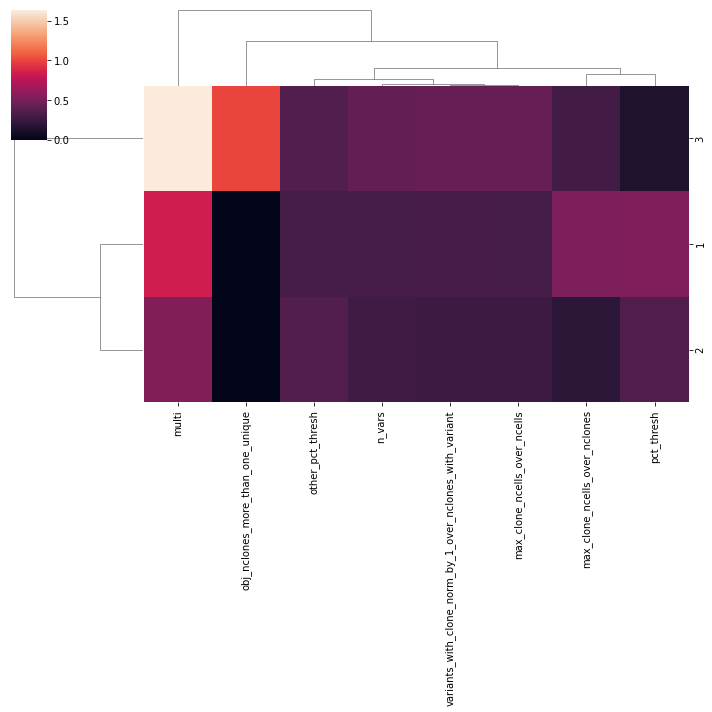

In [14]:
sns.clustermap(results_norm)
plt.savefig(join(outdir, "top_param_group_results.png"))
plt.savefig(join(outdir, "top_param_group_results.pdf"), bbox_inches='tight', pad_inches=1)

## Plot cluster clone-var table

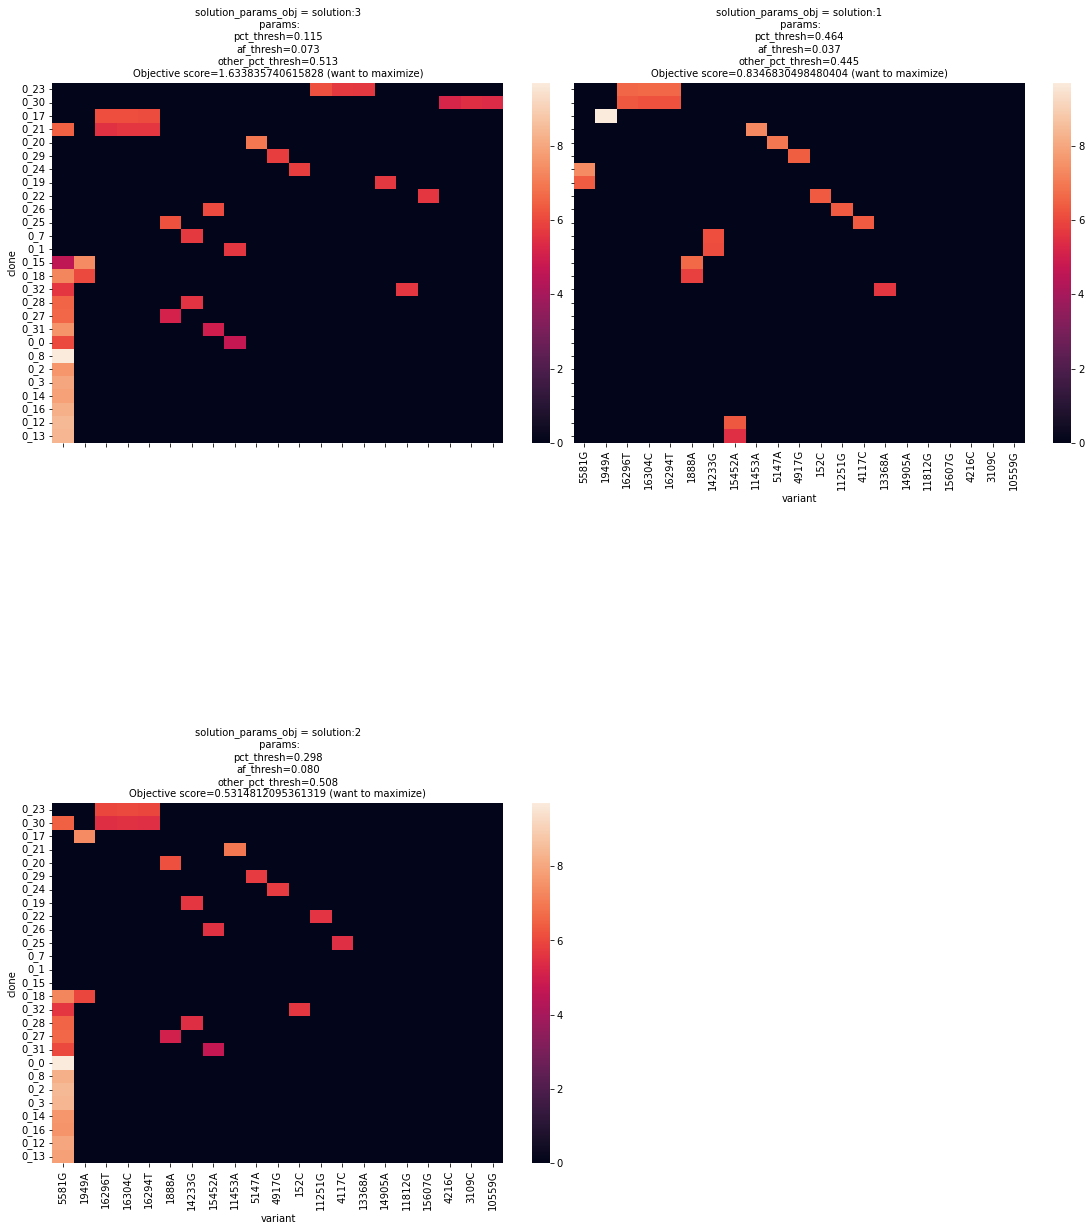

In [15]:
fg = sns.FacetGrid(data=all_df.reset_index(), height=4, aspect=2, sharey=True, sharex=True, 
                   col="solution_params_obj", col_wrap=2, 
                   col_order=results_norm_params["solution_params_obj"].values, margin_titles=False)

fg.map_dataframe(optim.draw_heatmap, 'variant','clone', 'log2_n_cells', 
                 clones_order=clones_order, 
                 variants_order=variants_order)#, cbar=False)
#fg.set_titles(row_template = 'other_pct_thresh: {row_name}', col_template = 'pct_thresh: {col_name}')
#fg.fig.suptitle(f"Best parameter combinations shown in order")
fg.fig.subplots_adjust(top=2, hspace = 1)

plt.savefig(join(outdir, "top_param_groups_clone_vars.pdf"), dpi=300, bbox_inches='tight', pad_inches=1)

In [16]:
for ind, val in all_df.groupby("solution_params_obj"):
    print(ind)
    curr_dir = join(outdir, "best_params_clusters")
    if not exists(curr_dir):
        os.mkdir(curr_dir)
    curr_name = val["params"][0].replace("=", "__").replace("\n", "___").strip("_")
    curr_table = val.reset_index().pivot(index="clone",columns="variant",values="n_cells").fillna(0).astype(int)
    curr_table.to_csv(join(curr_dir, f"clone_variants.{curr_name}.csv"))

solution:1
 params:
pct_thresh=0.464
af_thresh=0.037
other_pct_thresh=0.445
Objective score=0.8346830498480404 (want to maximize)
solution:2
 params:
pct_thresh=0.298
af_thresh=0.080
other_pct_thresh=0.508
Objective score=0.5314812095361319 (want to maximize)
solution:3
 params:
pct_thresh=0.115
af_thresh=0.073
other_pct_thresh=0.513
Objective score=1.633835740615828 (want to maximize)


## Get the top cluster score and save 

In [17]:
best_params = (results_norm_params.sort_values("multi_obj")[::-1]).iloc[0]
best_params

best_params = pd.DataFrame(best_params).transpose()
best_params.index = ["objective_scores"]
best_params.loc["weight"] = None

for obj, w in zip(objectives_l, weights):
    best_params.loc["weight", f"{obj}_obj"] = w

out_df = all_df[all_df['params'] == best_params.loc["objective_scores", "params"]]

clone_var_table = (out_df.pivot(index= 'variant',columns='clone', values='log2_n_cells').fillna(0))
clones_keep = clone_var_table.loc[:, ~((clone_var_table==0).all(axis=0))].columns
vars_keep = clone_var_table.loc[~((clone_var_table==0).all(axis=1))].index


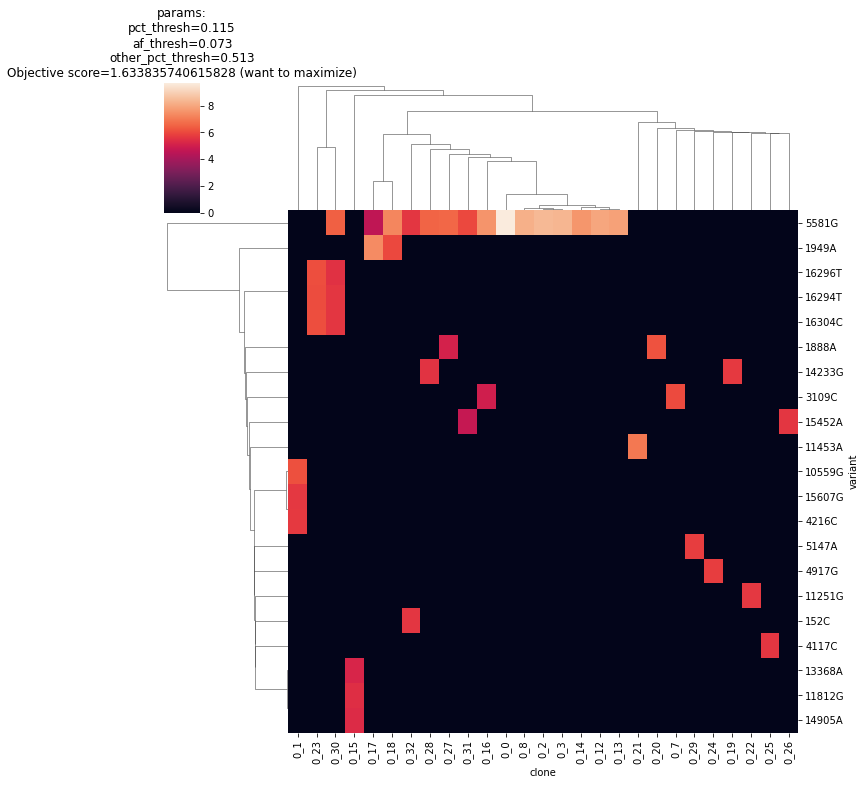

In [18]:
sns.clustermap(clone_var_table)
plt.title(best_params.loc["objective_scores", "params_multi"])
plt.savefig(join(outdir, "best_params.pdf"), bbox_inches='tight', pad_inches=1)

# sns.clustermap(clone_var_table.loc[vars_keep,clones_keep])
# plt.title(best_params.loc["objective_scores", "params_multi"])
# plt.savefig(join(outdir, "best_params_filt.pdf"))



In [19]:
# ## Save clone-variant table and the parameters
clone_var_table.to_csv(join(outdir, "best_params_clone_vars.csv"))
clone_var_table.loc[vars_keep,clones_keep].to_csv(join(outdir, "best_params_filt_clone_vars.csv"))
best_params.to_csv(join(outdir, "best_params.csv"))

anno_cells = pd.read_csv(anno_cells_meta_f, sep="\t", index_col=0)

filt_curr_labels = curr_labels[curr_labels["name"].isin(clones_keep)]

# overlap cells of anno and curr labels
cells_to_keep = set(anno_cells["ID"].values).intersection(set(filt_curr_labels.index))
out_cells_meta = anno_cells.loc[anno_cells["ID"].isin(cells_to_keep)]
#out_cells_meta =  out_cells_meta.reset_index().set_index("ID")

# out_AF_df = AF_df.loc[vars_keep, out_cells_meta.index]
# out_DP_df = DP_df.loc[vars_keep, out_cells_meta.index]
print(out_cells_meta.head())
out_AF_df = AF_df.loc[vars_keep, out_cells_meta["ID"]].transpose()
out_DP_df = DP_df.loc[vars_keep, out_cells_meta["ID"]].transpose()


print(out_cells_meta.shape)
print(out_AF_df.shape)
print(out_DP_df.shape)

assert((out_AF_df.index==out_DP_df.index).all())
assert((out_AF_df.columns==out_DP_df.columns).all())
assert((out_AF_df.index==out_cells_meta["ID"]).all())


# ## save cells-meta, af and dp
out_cells_meta["ID"]

out_cells_meta.to_csv(join(outdir, "cells_meta.tsv"),sep="\t")
out_AF_df.to_csv(join(outdir, "af.tsv"), sep="\t")
out_DP_df.to_csv(join(outdir, "dp.tsv"), sep="\t")

outdir



                         orig.ident  nCount_ATAC  nFeature_ATAC  total  \
Flt3l_AAACGAACAAGCGAAC-1      Flt3l         2271           2271   8825   
Flt3l_AAACGAACACAGCCAC-1      Flt3l         2854           2854  10589   
Flt3l_AAACGAACACAGGTAG-1      Flt3l          615            615   2384   
Flt3l_AAACGAACATAGAATG-1      Flt3l          985            985   3395   
Flt3l_AAACGAAGTATTCGAC-1      Flt3l          894            894   4999   

                          duplicate  chimeric  unmapped  lowmapq  \
Flt3l_AAACGAACAAGCGAAC-1       1544        24        24      535   
Flt3l_AAACGAACACAGCCAC-1       1294        41        31      456   
Flt3l_AAACGAACACAGGTAG-1        240        13         7      149   
Flt3l_AAACGAACATAGAATG-1        433         8        20      163   
Flt3l_AAACGAAGTATTCGAC-1        553        16        17      197   

                          mitochondrial  passed_filters  ... seurat_clusters  \
Flt3l_AAACGAACAAGCGAAC-1           1308            5390  ...      

'/data/Mito_Trace/output/pipeline/v04/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/enriched_barcodes/clones/variants_init/knn/kparam_30/donor0/optim_results/'

In [20]:
#all_df["params_multi"] = all_df.apply(optim.params_and_multi_str, axis=1)
# ########################
# # Get the top n results
# ########################
# def get_top_n_results(results_df, rank_df, n=12):
#     filt_rank = rank_df.sort_values(by=["multi"])[::-1].iloc[:n]
#     filt_results = results_df.loc[filt_rank.index]
#     return filt_rank, filt_results


# full_params.to_csv(join(outdir, "params.csv"))

# filt_rank, filt_results = get_top_n_results(results_df, rank_df, n=topn)
# filt_results.columns = [f"{x}_obj" for x in filt_results.columns]
# filt_results = pd.merge(filt_results, full_params, left_index=True, right_index=True, how="left")
# filt_rank = filt_rank.loc[filt_results.index]

# all_df = []
# all_objs = {}
# for ind, val in filt_results.iterrows():
#     print(ind)
#     obj_out, data = optim.evaluate_series(val, AF_df, DP_df, curr_labels, return_data=True)
#     all_df.append(data["all_unique_df"])
#     all_objs[ind] = obj_out 
# all_df = pd.concat(all_df)

# heatmap_input = all_df[["n_cells", "variant"]].reset_index().pivot(index="id", columns="variant", values="n_cells").fillna(0).astype(int)
# meta_df = all_df[["af_thresh", "other_pct_thresh", "pct_thresh", "clone"]]
# meta_df = meta_df.loc[~(meta_df.index.duplicated())]
# meta_df = meta_df.sort_values(["af_thresh","pct_thresh", "other_pct_thresh", "clone"])
# heatmap_input = heatmap_input.loc[meta_df.index]

# # Get the variants based on total number of cells across parameters
# heatmap_input = heatmap_input.loc[:,heatmap_input.sum().sort_values()[::-1].index]
# variants_order = heatmap_input.columns


# clone_sums = meta_df.groupby("clone").apply(optim.clone_sum, heatmap_input)
# clone_sums = clone_sums.loc[:, clone_sums.sum().sort_values()[::-1].index]
# clones_order = clone_sums.index

# all_df["params"] = all_df.apply(optim.params_to_str, axis=1, args=(param_names,))
# filt_results["params"] = filt_results.apply(optim.params_to_str, axis=1, args=(param_names,))
# filt_results["params_multi"] = filt_results.apply(optim.params_and_multi_str, axis=1)
# tmp = filt_results.set_index("params")
# all_df["multi_obj"] = all_df.apply(lambda x: tmp.loc[x["params"], "multi_obj"], axis=1)
# del tmp                               

# all_df["params_multi"] = all_df.apply(optim.params_and_multi_str, axis=1)


# fg = sns.FacetGrid(data=all_df.reset_index(), height=4, sharey=False, sharex=False,
#                    col="params", col_wrap=4, col_order=filt_results["params"].values, margin_titles=True)

# fg.map_dataframe(optim.draw_heatmap, 'variant','clone', 'log2_n_cells',
#                  clones_order=clones_order, variants_order=variants_order)#, cbar=False)

# #fg.set_titles(row_template = 'other_pct_thresh: {row_name}', col_template = 'pct_thresh: {col_name}')
# fg.fig.suptitle(f"Best parameter combinations shown in order")
# fg.fig.subplots_adjust(top=0.9, hspace = 0.8)

# plt.title("multiobjective function (want to maximize)")
# #plt.savefig(join(outdir, "top_param_results.pdf"))
# plt.savefig(join(outdir, "top_param_results.pdf"), dpi=300)